In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/MIT_ISOLAT-Mixtures'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

60

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,location,quantile,target,target_end_date,type,value
4288,2021-01-17,42,NaN,1 wk ahead inc case,2021-01-23,point,54373.656710
4296,2021-01-17,42,NaN,2 wk ahead inc case,2021-01-30,point,58991.270263
4304,2021-01-17,42,NaN,3 wk ahead inc case,2021-02-06,point,65215.848427
4312,2021-01-17,42,NaN,4 wk ahead inc case,2021-02-13,point,72436.206406
4288,2021-01-25,42,NaN,1 wk ahead inc case,2021-01-30,point,41377.911327


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,location,quantile,target,target_end_date,type,value
4288,2021-01-17,42,NaN,1 wk ahead inc case,2021-01-23,point,54373.656710
4296,2021-01-17,42,NaN,2 wk ahead inc case,2021-01-30,point,58991.270263
4288,2021-01-25,42,NaN,1 wk ahead inc case,2021-01-30,point,41377.911327
4304,2021-01-17,42,NaN,3 wk ahead inc case,2021-02-06,point,65215.848427
4296,2021-01-25,42,NaN,2 wk ahead inc case,2021-02-06,point,39356.542868
...,...,...,...,...,...,...,...
4400,2022-02-28,42,NaN,3 wk ahead inc case,2022-03-19,point,1172.275544
4408,2022-02-28,42,NaN,4 wk ahead inc case,2022-03-26,point,373.204848
4072,2022-03-14,42,NaN,2 wk ahead inc case,2022-03-26,point,59.550261
4080,2022-03-14,42,NaN,3 wk ahead inc case,2022-04-02,point,16.965215


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(45, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [54]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2021-05-01')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,location,quantile,target,type,value,dayRate
0,2021-01-23,2021-01-17,42,NaN,1 wk ahead inc case,point,54373.656710,7767.665244
1,2021-01-30,2021-01-25,42,NaN,1 wk ahead inc case,point,41377.911327,5911.130190
2,2021-02-06,2021-02-01,42,NaN,1 wk ahead inc case,point,35676.428355,5096.632622
3,2021-02-13,2021-02-08,42,NaN,1 wk ahead inc case,point,25131.962532,3590.280362
4,2021-02-20,2021-02-15,42,NaN,1 wk ahead inc case,point,15834.412924,2262.058989


In [55]:
df_weekly.tail(5)

,Date,forecast_date,location,quantile,target,type,value,dayRate
10,2021-04-03,2021-03-29,42,NaN,1 wk ahead inc case,point,29672.841309,4238.977330
11,2021-04-10,2021-04-05,42,NaN,1 wk ahead inc case,point,29925.599247,4275.085607
12,2021-04-17,2021-04-12,42,NaN,1 wk ahead inc case,point,34149.150004,4878.450001
13,2021-04-24,2021-04-19,42,NaN,1 wk ahead inc case,point,35878.133105,5125.447586
14,2021-05-01,2021-04-26,42,NaN,1 wk ahead inc case,point,29224.678761,4174.954109


In [56]:
len(df_weekly)

15

In [57]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[7767.665244272966, 7767.665244272966, 7767.665244272966, 7767.665244272966, 7767.665244272966, 7767.665244272966, 7767.665244272966, 5911.130189524615, 5911.130189524615, 5911.130189524615, 5911.130189524615, 5911.130189524615, 5911.130189524615, 5911.130189524615, 5096.63262219511, 5096.63262219511, 5096.63262219511, 5096.63262219511, 5096.63262219511, 5096.63262219511, 5096.63262219511, 3590.2803616605897, 3590.2803616605897, 3590.2803616605897, 3590.2803616605897, 3590.2803616605897, 3590.2803616605897, 3590.2803616605897, 2262.0589891989553, 2262.0589891989553, 2262.0589891989553, 2262.0589891989553, 2262.0589891989553, 2262.0589891989553, 2262.0589891989553, 2306.7833252218898, 2306.7833252218898, 2306.7833252218898, 2306.7833252218898, 2306.7833252218898, 2306.7833252218898, 2306.7833252218898, 2227.7210715065617, 2227.7210715065617, 2227.7210715065617, 2227.7210715065617, 2227.7210715065617, 2227.7210715065617, 2227.7210715065617, 1881.8615159681083, 1881.8615159681083, 1881.86

In [58]:
len(predictions)

105

In [65]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2021-01-23') & (df1['Date'] <= '2021-05-07')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2021-01-23,7646,10339.2,1624822,25603978,2319.3,4170.2,442920.2,2860489,-5275.682283,2774.207671
1,2021-01-24,7576,10285.1,1632398,25603978,2098.0,3877.1,445018.1,2860489,-5275.682283,2774.207671
2,2021-01-25,10216,10136.1,1642614,25603978,2756.5,3838.7,447774.3,2860489,-5275.682283,2774.207671
3,2021-01-26,11186,10116.1,1653800,25603978,3065.4,3791.8,450839.5,2860489,-5275.682283,2774.207671
4,2021-01-27,13992,10452.1,1667792,25603978,3358.8,2861.4,454198.1,2860489,-5275.682283,2774.207671


In [66]:
df1_copy.tail(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
100,2021-05-03,6638,6346.7,2347688,25603978,1784.7,1658.6,622703.6,2860489,-5275.682283,2774.207671
101,2021-05-04,5614,6185.1,2353302,25603978,1694.9,1659.8,624398.4,2860489,-5275.682283,2774.207671
102,2021-05-05,4936,5802.9,2358238,25603978,1408.7,1574.8,625807.7,2860489,-5275.682283,2774.207671
103,2021-05-06,6160,5407.0,2364398,25603978,1722.3,1485.9,627529.8,2860489,-5275.682283,2774.207671
104,2021-05-07,5202,5263.0,2369600,25603978,1494.4,1464.4,629024.4,2860489,-5275.682283,2774.207671


In [67]:
len(df1_copy)

105

In [68]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [69]:
df1_copy.head(20)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction
0,2021-01-23,7646,10339.2,1624822,25603978,2319.3,4170.2,442920.2,2860489,-5275.682283,2774.207671,7767.665244
1,2021-01-24,7576,10285.1,1632398,25603978,2098.0,3877.1,445018.1,2860489,-5275.682283,2774.207671,7767.665244
2,2021-01-25,10216,10136.1,1642614,25603978,2756.5,3838.7,447774.3,2860489,-5275.682283,2774.207671,7767.665244
3,2021-01-26,11186,10116.1,1653800,25603978,3065.4,3791.8,450839.5,2860489,-5275.682283,2774.207671,7767.665244
4,2021-01-27,13992,10452.1,1667792,25603978,3358.8,2861.4,454198.1,2860489,-5275.682283,2774.207671,7767.665244
5,2021-01-28,16848,11318.0,1684640,25603978,4458.2,3051.2,458655.9,2860489,-5275.682283,2774.207671,7767.665244
6,2021-01-29,10994,11208.6,1695634,25603978,3510.3,3081.2,462166.3,2860489,-5275.682283,2774.207671,7767.665244
7,2021-01-30,7918,11247.1,1703552,25603978,2178.0,3061.1,464344.7,2860489,-5275.682283,2774.207671,5911.130190
8,2021-01-31,6710,11123.4,1710262,25603978,1754.7,3011.9,466099.9,2860489,-5275.682283,2774.207671,5911.130190
9,2021-02-01,7508,10736.6,1717770,25603978,2061.1,2911.9,468160.5,2860489,-5275.682283,2774.207671,5911.130190


In [70]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [71]:
merged_df_new.shape

(105, 12)

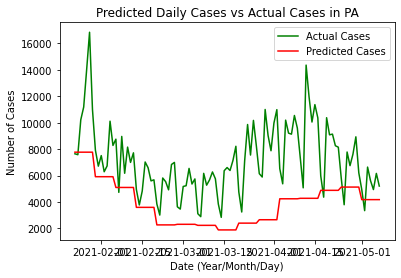

In [72]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [73]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

99
0.9428571428571428
6
0.05714285714285716
105
[0.015912273642815385, 0.02529900267594594, 0.2396568868174465, 0.30559044839326244, 0.44484953943160616, 0.5389562414367898, 0.29346323046452916, 0.2534566570441254, 0.11905660364759833, 0.2126891063499447, 0.05963566822707363, 0.12141346766875517, 0.4155497143044676, 0.28592290534856063, 0.4176608064219481, 0.07842416889443724, 0.43117939484429574, 0.17396553935249426, 0.3747997274049178, 0.27128501255431653, 0.3396433503245517, 0.27322259885413164, 0.04817593805392637, 0.25574619368561574, 0.48885530158590695, 0.45535795484517755, 0.3581908541900984, 0.3672399785582323, 0.41122878990136513, 0.24748536620127903, 0.6107950810049974, 0.5913910785406511, 0.5400449391624735, 0.6690961104156006, 0.6765714913927717, 0.36487243248295986, 0.3329140181544564, 0.5539862093538496, 0.5587637097892331, 0.6471729389382243, 0.5693085651191393, 0.5982613505360693, 0.2832300284727923, 0.2280938768168532, 0.6385916496582477, 0.5772825291258896, 0.6071038

In [74]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.9840877263571847, 0.974700997324054, 0.7603431131825535, 0.6944095516067376, 0.5551504605683939, 0.4610437585632102, 0.7065367695354708, 0.7465433429558745, 0.8809433963524017, 0.7873108936500552, 0.9403643317729263, 0.8785865323312448, 0.5844502856955325, 0.7140770946514394, 0.582339193578052, 0.9215758311055627, 0.5688206051557043, 0.8260344606475057, 0.6252002725950823, 0.7287149874456835, 0.6603566496754483, 0.7267774011458683, 0.9518240619460736, 0.7442538063143842, 0.511144698414093, 0.5446420451548224, 0.6418091458099016, 0.6327600214417677, 0.5887712100986349, 0.752514633798721, 0.38920491899500265, 0.4086089214593489, 0.45995506083752646, 0.3309038895843994, 0.32342850860722827, 0.6351275675170401, 0.6670859818455436, 0.44601379064615043, 0.44123629021076693, 0.35282706106177575, 0.4306914348808607, 0.4017386494639307, 0.7167699715272078, 0.7719061231831468, 0.36140835034175234, 0.4227174708741104, 0.39289613254083977, 0.3552984165082236, 0.3872950402480114, 0.4895581467138

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

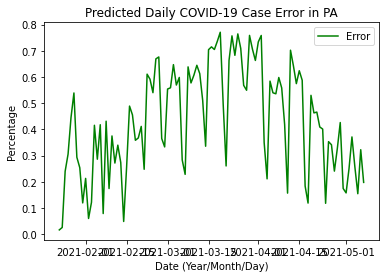

In [76]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

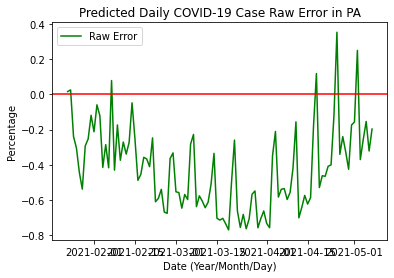

In [77]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

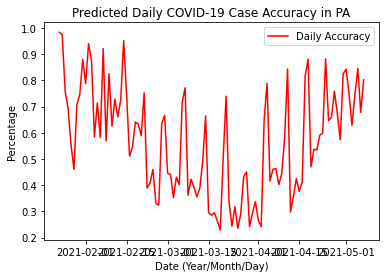

In [78]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [79]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [80]:
len(weeklyDateList)

16

In [82]:
del weeklyDateList[-1:]
len(averageWeeklyAccuracy)

15

In [83]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

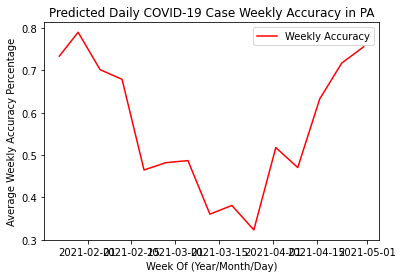

In [84]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [85]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [86]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

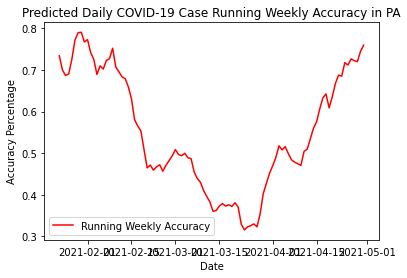

In [87]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

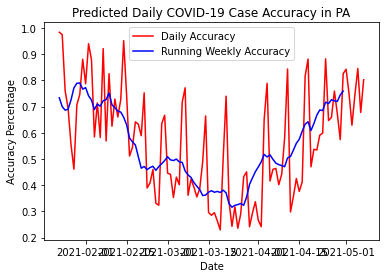

In [88]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [89]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [90]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [91]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

4

In [92]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

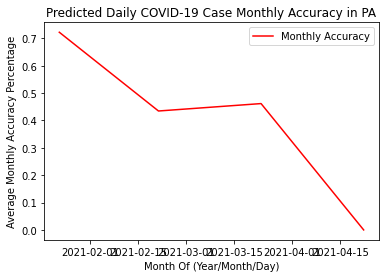

In [93]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [94]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [95]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

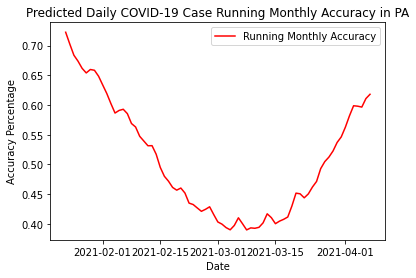

In [96]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [97]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021

In [98]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [100]:
merged_df_new.index[merged_df_new['Date']=='2021-05-07'].tolist()

[104]

In [101]:
#print(merged_inner)
standardVariantDF = merged_df_new[:104]

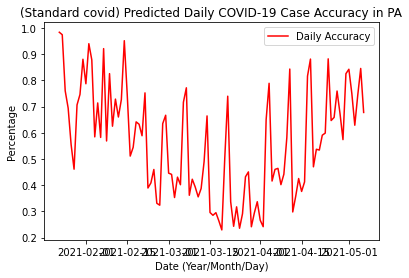

In [102]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()